# WCS plate solving

```{important}
This tutorial requires the extra packages:
- [photutils](https://photutils.readthedocs.io/)
- [scipy](https://scipy.org/)
- [scikit-image](https://scikit-image.org/)
- [pandas](https://pandas.pydata.org/)
```

In this example, we use [photutils](https://photutils.readthedocs.io/) to detect some stars in an example image, and find its WCS based on the RA-DEC of the image and the telescope field-of-view

## Image and sources

We start by loading an example image from photutils

In [1]:
from photutils.datasets import load_star_image
from astropy.stats import sigma_clipped_stats
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

hdu = load_star_image()
data, true_wcs = hdu.data, WCS(hdu.header)
mean, median, std = sigma_clipped_stats(data, sigma=3.0)

Changed DATE-OBS from '29/11/51          ' to '1951-11-29''. [astropy.wcs.wcs]


And we detect few of the brighest sources in the image, that will be compared to catalog stars to compute the WCS

In [2]:
from twirl import find_peaks

xy = find_peaks(data)[0:20]

Here is our field and reference stars

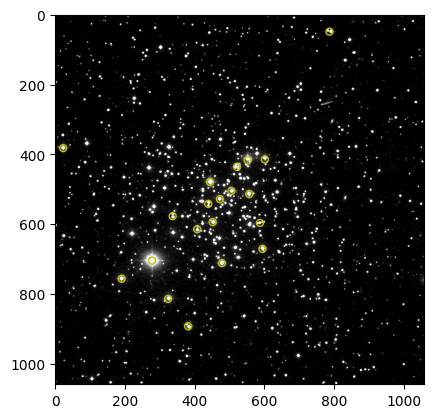

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture

plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=10.0).plot(color="y")


## Plate solving

We can now plate solve using twirl. 

We first compute the center RA-DEC of the image and its field-of-view (usually known for a given telescope but taken here from the original wcs)

In [4]:
from astropy.wcs.utils import proj_plane_pixel_scales

fov = (data.shape * proj_plane_pixel_scales(true_wcs))[0]
center = true_wcs.pixel_to_world(*np.array(data.shape) / 2)


We query the Gaia stars RA-DEC in this field (a bit larger to have more stars)

In [5]:
from twirl import gaia_radecs
from twirl.geometry import sparsify

all_radecs = gaia_radecs(center, 1.2 * fov)

# we only keep stars 0.01 degree apart from each other
all_radecs = sparsify(all_radecs, 0.01)


And we compute the wcs based on the detected stars against the queried Gaia stars

In [8]:
from twirl import compute_wcs

# we only keep the 12 brightest stars from gaia
wcs = compute_wcs(xy, all_radecs[0:30], tolerance=10)


We can now over-plot the gaia stars based on their RA-DEC using the inferred WCS

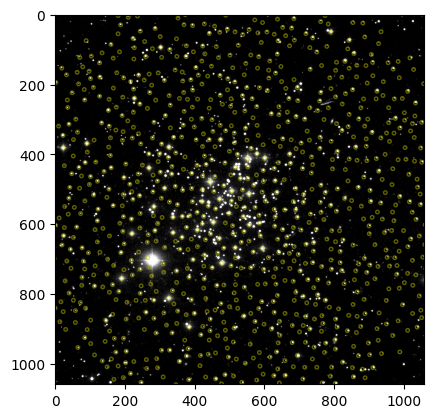

In [11]:
# plotting to check the WCS
radecs_xy = np.array(wcs.world_to_pixel_values(all_radecs))
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(radecs_xy, 5).plot(color="y", alpha=0.5)

This validates our WCS solution 